# Role of Atmospheric Correction

Code to reproduce Figure 8

execute this notebook in the `notebooks` subfolder of the [marinedebrisdetector](https://github.com/marcCoru/marinedebrisdetector) repository

In [1]:
import sys
import os

import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
import skimage.feature
import numpy as np
import torch

sys.path.append("..") # paths relative to repository root
from visualization import rgb
from data.durban import annotated_objects

%matplotlib inline

download of durban data and model used in the paper

In [2]:
checkpoint_url = "https://marinedebrisdetector.s3.eu-central-1.amazonaws.com/models/unet%2B%2B_durban.zip"
data_url = "https://marinedebrisdetector.s3.eu-central-1.amazonaws.com/data/durban.zip"

# unzip and download
!wget -nc {checkpoint_url}
!unzip -n unet++_durban.zip

!wget -nc {data_url}
!unzip -n durban.zip

File ‘unet++_durban.zip’ already there; not retrieving.

Archive:  unet++_durban.zip
File ‘durban.zip’ already there; not retrieving.

Archive:  durban.zip


setup of paths

In [3]:
checkpoint_folder = "unet++_durban"
data_folder = "durban"
write_path = "/tmp/results"

checkpoint_file = f"{checkpoint_folder}/epoch=89-val_loss=0.52.ckpt"
prediction_file_l2a = f"{checkpoint_folder}/test_scenes/durban_prediction.tif"
prediction_file_l1c = f"{checkpoint_folder}/test_scenes/durban_l1c_prediction.tif"

annotation_file = f'{data_folder}/durban_20190424_annotated.tif'
image_file_l2a = f'{data_folder}/durban_20190424.tif'
image_file_l1c = f'{data_folder}/durban_20190424_l1c.tif'

retrieval of the threshold for classification of this model

In [4]:
threshold = float(torch.load(checkpoint_file)["state_dict"]["threshold"])
print(threshold)

0.05670391023159027


setup of extraction functions

In [5]:
def get_confusions(prediction_file, annotation_file, threshold):

    with rio.open(prediction_file, "r") as src:
        predictions = src.read(1) / 255

    prediction = predictions > threshold

    peaks = skimage.feature.peak_local_max(predictions, threshold_abs=threshold, min_distance=3)

    with rio.open(annotation_file, "r") as src:
        annotations = src.read().transpose(1,2,0)

    # add water (not annotated at all to the annotations)
    water = annotations.sum(2) == 0

    annotations = np.dstack([annotations, water[:,:,None]])

    annotated_objects_all = annotated_objects + ["water"]

    prediction[peaks[:,0], peaks[:,1]]
    annotated_peaks = annotations[peaks[:,0], peaks[:,1]]

    instance, class_ids = np.where(annotated_peaks)

    anot, counts = np.unique(class_ids, return_counts=True)

    # initialize empty
    df = pd.DataFrame([annotated_objects_all, np.zeros(len(annotated_objects_all))], index=["name", "counts"]).T.set_index("name")

    # fill with values
    for a, c in zip(np.array(annotated_objects_all)[anot], counts):
        df.loc[a] = c
        
    p_annot = annotated_peaks.argmax(1)
    p_peaks = np.hstack([peaks, p_annot[:,None]])

    return df, p_peaks, annotated_objects_all

def plot_detections(p_peaks, image_file):

    with rio.open(image_file, "r") as src:
        img = src.read()

    from matplotlib import colors
    debriscolor = "#FF0000"
    shipscolor = "#FBEE66"
    coastlinecolor = "#5C2483"
    landcolor = "#00A79F"
    cloudscolor = "#C8D300"
    hazedense = "#5B3428"
    hazetrans = "#CAC7C7"
    watercolor = "#4F8FCC"
    cmapcolors = [debriscolor, shipscolor, landcolor, coastlinecolor, cloudscolor, hazedense, hazetrans, watercolor]

    cmap = colors.LinearSegmentedColormap.from_list("debris", cmapcolors)

    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(rgb(img).transpose(1,2,0))
    ax.scatter(p_peaks[:,1], p_peaks[:,0], c=p_peaks[:,2], s=15, cmap=cmap, linewidths=0.5)
    ax.axis("off")
    return fig

top-of-atmosphere predictions

                 counts
name                   
debris              164
ships                18
land                 58
coastline            15
cummulus_clouds      41
haze_dense          142
haze_transparent    600
water               446
writing plot to /tmp/results/detections_l1c.png


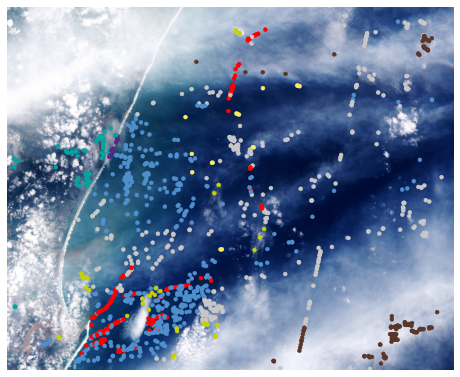

In [6]:
df, p_peaks, annotated_objects_all = get_confusions(prediction_file_l1c, annotation_file, threshold)
df.loc[["debris", "haze_transparent", "haze_dense", "cummulus_clouds", "ships", "land", "coastline", "water"]]
print(df)
fig = plot_detections(p_peaks, image_file_l1c)

os.makedirs(write_path, exist_ok=True)
writefile = os.path.join(write_path,"detections_l1c.png")
print(f"writing plot to {writefile}")
fig.savefig(writefile, bbox_inches="tight", pad_inches=0)

bottom-of-atmosphere predictions

                 counts
name                   
debris              136
ships                16
land                 92
coastline            26
cummulus_clouds      14
haze_dense          0.0
haze_transparent     98
water               227
writing plot to /tmp/results/detections_l2a.png


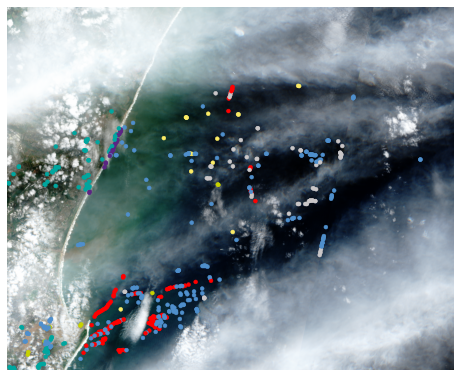

In [7]:
df, p_peaks, annotated_objects_all = get_confusions(prediction_file_l2a, annotation_file, threshold)
df.loc[["debris", "haze_transparent", "haze_dense", "cummulus_clouds", "ships", "land", "coastline", "water"]]
print(df)

fig = plot_detections(p_peaks, image_file_l2a)
os.makedirs(write_path, exist_ok=True)
writefile = os.path.join(write_path,"detections_l2a.png")
print(f"writing plot to {writefile}")
fig.savefig(writefile, bbox_inches="tight", pad_inches=0)

